In [1]:
import sys,os
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display

#os.chdir("/content")
#from colorsetup import colors, palette
#sns.set_palette(palette)

# ignore warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plotsize = (13, 5)
plt.rcParams['figure.figsize'] = plotsize

In [2]:
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)

import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [3]:
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)

In [4]:
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (#ModelSpec as MS,
                         summarize) # the enclosing round parentheses is to write codes in multiple lines. 
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
# 

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
#!pip install l0bnb #[yw] in case error" "Numba needs Numpy 1.20 or less", upgrade Numba by: pip install numba --upgrade
from l0bnb import fit_path

In [6]:
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl

from ISLP import load_data

from functools import partial

In [7]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART


In [104]:
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay

In [8]:
# User defined parameters. Change as needed. 
DATA_FILE_PATH = 'apple_20240301.csv' # csv file to save the downloaded data
MV_AVG_WINDOW = 100 #moving avg window size to normalize the volume data
STOCK_MV_DIRECTION_THRESHOLD = 0 # return treshold to determine the stock movement direction
TEST_START_DATE = '2022-12-25' #testing start date 
#this date is chosen to make sure that the last batch, 
# when using batch size 64, has at least two examples. The last batch must have at least two examples 
# to computer R^2  when using Torch NN. 
MAX_LAG = 5

In [9]:
## Obtain the data and write it to a csv file. Run it only once unless you want to update data
# apple = yf.Ticker("AAPL")
# apple_share_price_data = apple.history(period="max")
# apple_share_price_data.to_csv(DATA_FILE_PATH)

In [10]:
# utility file
def read_data(csv_file='apple_df.csv',dc='Date', verbose = False):
  """
  Read a csv file into a dataframe and convert the date string into a date index
  INPUT: 
  csv_file: complete csv_file path including file name
  dc: Date column name
  OUTPUT: 
  df: a dataFrame with date value as index
  """
  df =pd.read_csv(csv_file)
  
  df[dc]=df[dc].apply(lambda x: x[:11])
  df.set_index(dc, inplace=True)
  df.index= pd.DatetimeIndex(df.index)
  if verbose: 
    print(df.head())
    print("\n")
    print("*"*20+"DataFrame Info"+"*"*20)
    df.info()
    print("\n")
    print(df.describe().transpose())
  return df

In [11]:
data_file_path = DATA_FILE_PATH
apple = read_data(data_file_path)
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10895 entries, 1980-12-12 to 2024-03-01
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          10895 non-null  float64
 1   High          10895 non-null  float64
 2   Low           10895 non-null  float64
 3   Close         10895 non-null  float64
 4   Volume        10895 non-null  int64  
 5   Dividends     10895 non-null  float64
 6   Stock Splits  10895 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 680.9 KB


In [12]:
# Data preprocessing utility
### remove the rows with Volume =0, on which there was no transaction 
apple = apple[apple['Volume'] != 0]

apple.drop(['Dividends','Stock Splits'], axis=1, inplace=True)
apple['month'] = apple.index.month
apple['month'] = apple['month'].astype('category')

apple['day_of_week'] = apple.index.day_name()
apple['day_of_week'] = apple['day_of_week'].astype('category')

day_order = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
apple['day_of_week'] = apple['day_of_week'].cat.set_categories(day_order)

apple['return']=np.log(apple.Close/(apple.Close.shift(1)))
apple['volatility'] = np.fabs(apple['return'])

window = MV_AVG_WINDOW
apple['log_volume'] = np.log(apple['Volume']/apple['Volume'].rolling(window).mean().shift(1)) 
#rolling creates 99 Nan, shift creates 1 nan: togeter 100 nan

direction_threshold = STOCK_MV_DIRECTION_THRESHOLD
apple['direction'] = apple['return'] > direction_threshold

apple.dropna(inplace=True)

apple['train'] =  ~(apple.index >= TEST_START_DATE )  #this date is chosen to make sure that the last batch, 
# when using batch size 64, has at least two examples. The last batch must have at least two examples 
# to computer R^2  when using Torch NN. 

In [13]:
apple.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'month', 'day_of_week',
       'return', 'volatility', 'log_volume', 'direction', 'train'],
      dtype='object')

In [14]:
#### Normalize the indicated columns with z-values
cols = ['return', 'log_volume', 'volatility']
X = pd.DataFrame(StandardScaler(
                     with_mean=True,
                     with_std=True).fit_transform(apple[cols]),
                 columns=apple[cols].columns,
                 index=apple.index)

In [15]:
# Calculate the lag columns of the columns above 
max_lag = MAX_LAG
for lag in range(1, max_lag+1):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)#insert at the end
X.insert(len(X.columns), 'train', apple['train']) #insert the col training identifier 
X = X.dropna() #drop max_lag=5 rows with nan


In [16]:
X.columns

Index(['return', 'log_volume', 'volatility', 'return_1', 'log_volume_1',
       'volatility_1', 'return_2', 'log_volume_2', 'volatility_2', 'return_3',
       'log_volume_3', 'volatility_3', 'return_4', 'log_volume_4',
       'volatility_4', 'return_5', 'log_volume_5', 'volatility_5', 'train'],
      dtype='object')

In [17]:
train_len, test_len = len(X[X['train']==True]), len(X[X['train']!=True])
print("train days: ", train_len, "test days: ", test_len)

train days:  10493 test days:  296


Note: 

- `X`: contains all the numerical columns (return, volativilty and log_volume) and the bool col `train` 
- `apple`: contains the categorial cols: `month` and `day_of_week`. 

These two dataframes should not be modified and should be treated as original dataframes. 

# Classification
## Logistic Regression using statsmodels

In [18]:
X_train, X_test = X.loc[X['train']], X.loc[~X['train']] # X[X['train'] == True] equiv to  X.loc[X['train']]
Y_train, Y_test = X_train['return']>0, X_test['return']>0 # generate the binary response: True is UP. 

In [19]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((10493, 19), (296, 19), (10493,), (296,))

In [20]:
predictors = ['return_5', 'return_4','return_3', 'return_2', 'return_1', 'log_volume_1']
design = MS(predictors)
X_train_5 = design.fit_transform(X_train)
y = Y_train
glm = sm.GLM(y,
             X_train_5,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.0495,0.020,-2.530,0.011
return_5,-0.0083,0.019,-0.429,0.668
return_4,0.0508,0.020,2.593,0.010
return_3,-0.0388,0.020,-1.979,0.048
return_2,-0.0680,0.020,-3.444,0.001
return_1,-0.0098,0.019,-0.507,0.612
log_volume_1,0.0203,0.019,1.046,0.296


In [21]:
X_test_5 = design.transform(X_test)
probs = results.predict(exog= X_test_5)

labels = probs > 0.5
confusion_table(labels, Y_test)

Truth,False,True
Predicted,,
False,133,131
True,14,18


In [22]:
### Test Accuracy
np.mean(labels == Y_test)


0.5101351351351351

In [23]:
# Using two lags
predictors = [ 'return_2', 'return_1']
design = MS(predictors)
X_train_2 = design.fit_transform(X_train)
y = Y_train
glm = sm.GLM(y,
             X_train_2,
             family=sm.families.Binomial())
results = glm.fit()
print(summarize(results), '\n')
X_test_2 = design.transform(X_test)
probs = results.predict(exog= X_test_2)

labels = probs > 0.5
print("Confusion Table: \n", confusion_table(labels, Y_test) )
### Test Accuracy
print("Test Accuracy: ", np.mean(labels == Y_test) )

             coef  std err      z  P>|z|
intercept -0.0494    0.020 -2.529  0.011
return_2  -0.0694    0.020 -3.515  0.000
return_1  -0.0101    0.019 -0.522  0.601 

Confusion Table: 
 Truth      False  True 
Predicted              
False        144    139
True           3     10
Test Accuracy:  0.5202702702702703


## Logistic Regression using SK-learn

In [24]:
X_train_2, X_test_2 = [M.drop(columns=['intercept']) #sklearn automatically adds an intercept, drop it from the design matrix by statsmodels
                   for M in [X_train_2, X_test_2]]

`sklearn`,  by default it fits
something like the *ridge regression* version
of logistic regression. This can
be modified by appropriately setting the argument `C` below. Its default
value is 1 but by setting it to a very large number, the algorithm converges to the same solution as the usual (unregularized)
logistic regression estimator discussed above.

In [25]:
logit = LogisticRegression(C=1e10, solver='liblinear')
logit.fit(X_train_2, Y_train)
logit_pred = logit.predict_proba(X_test_2)
logit_labels = np.where(logit_pred[:,1] > .5, True, False)
confusion_table(logit_labels, Y_test)

Truth,False,True
Predicted,,
False,144,139
True,3,10


In [26]:
# Logistic accuracy
np.mean(logit_labels == Y_test)

0.5202702702702703

## LDA using Sk-learn

In [27]:
lda = LDA(store_covariance=True) #store the covariance of each class

lda.fit(X_train_2, Y_train) # note sklearn use the order X,Y, opposite the order used by statsmodels: Y, X

LinearDiscriminantAnalysis(store_covariance=True)

In [28]:
lda.means_ #array-like of shape (n_classes, n_features)

array([[ 0.03383844,  0.0050342 ],
       [-0.03609458, -0.0059984 ]])

In [29]:
lda.classes_, lda.priors_

(array([False,  True]), array([0.51234156, 0.48765844]))

In [30]:
lda.scalings_ #Scaling of the features in the space spanned by the class centroids. 
# Only available for ‘svd’ and ‘eigen’ solvers.

array([[-0.97727746],
       [-0.14330167]])

These values provide the linear combination of `Lag1`  and `Lag2`  that are used to form the LDA decision rule (boundary). In other words, these are the multipliers of the elements of $X=x$ in (4.24).
  If $-0.977\times `Lag1`  - 0.143 \times `Lag2` $ is large, then the LDA classifier will predict a market increase, and if it is small, then the LDA classifier will predict a market decline. 

In [31]:
lda_pred = lda.predict(X_test_2)
confusion_table(lda_pred, Y_test)

Truth,False,True
Predicted,,
False,144,139
True,3,10


In [32]:
# LDA accuracy
np.mean(lda_pred == Y_test)

0.5202702702702703

In [33]:
lda_prob = lda.predict_proba(X_test_2) #ndarray of shape (n_samples, n_classes)
np.all(
       np.where(lda_prob[:,1] >= 0.5, True, False) == lda_pred
       )

True

## QDA using Sk-Learn

In [34]:
qda = QDA(store_covariance=True)
qda.fit(X_train_2, Y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [35]:
qda.means_, qda.priors_

(array([[ 0.03383844,  0.0050342 ],
        [-0.03609458, -0.0059984 ]]),
 array([0.51234156, 0.48765844]))

In [36]:
qda.covariance_[0], qda.covariance_[1] #Covariance of each class

(array([[ 1.10241163, -0.00317939],
        [-0.00317939,  1.06730139]]),
 array([[0.93688266, 0.02681325],
        [0.02681325, 0.97636331]]))

In [37]:
qda_pred = qda.predict(X_test_2)
confusion_table(qda_pred, Y_test)

Truth,False,True
Predicted,,
False,13,21
True,134,128


In [38]:
# QDA Accuracy
np.mean(qda_pred == Y_test)  # much worse than LDA

0.47635135135135137

## Naive Bayes

In [39]:
NB = GaussianNB()
NB.fit(X_train_2, Y_train)

GaussianNB()

In [40]:
NB.classes_, NB.class_prior_, 

(array([False,  True]), array([0.51234156, 0.48765844]))

In [41]:
NB.theta_  # class mean, 

array([[ 0.03383844,  0.0050342 ],
       [-0.03609458, -0.0059984 ]])

In [42]:
NB.var_ # Class variance

array([[1.10220657, 1.06710286],
       [0.93669957, 0.97617251]])

In [43]:
nb_labels = NB.predict(X_test_2)
confusion_table(nb_labels, Y_test)

Truth,False,True
Predicted,,
False,12,18
True,135,131


In [44]:
# NB Accuracy
np.mean(nb_labels == Y_test)  # much worse than LDA

0.4831081081081081

## KNN

In [45]:
knn1 = KNeighborsClassifier(n_neighbors=1)
X_train_2, X_test_2 = [np.asarray(X) for X in [X_train_2, X_test_2]]
knn1.fit(X_train_2, Y_train)
knn1_pred = knn1.predict(X_test_2)
confusion_table(knn1_pred, Y_test)

Truth,False,True
Predicted,,
False,79,79
True,68,70


In [46]:
# Accuracy
np.mean(knn1_pred == Y_test)

0.5033783783783784

In [47]:
knn3 = KNeighborsClassifier(n_neighbors=3)
X_train_2, X_test_2 = [np.asarray(X) for X in [X_train_2, X_test_2]]
knn3.fit(X_train_2, Y_train)
knn3_pred = knn3.predict(X_test_2)
confusion_table(knn1_pred, Y_test)

Truth,False,True
Predicted,,
False,79,79
True,68,70


In [48]:
np.mean(knn3_pred == Y_test)

0.4594594594594595

In [49]:
### Tuning the KNN parameters
for K in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train_2, Y_train).predict(X_test_2)
    C = confusion_table(knn_pred, Y_test)
    templ = ('K={0:d}: # predicted to Go up: {1:>2},' +  # > for right alighment
            '  # which did Go up {2:d}, accuracy {3:.1%}')
    pred = C.loc[True].sum()
    did_up = C.loc[True,True]
    print(templ.format(
          K,
          pred,
          did_up,
          did_up / pred))


K=1: # predicted to Go up: 138,  # which did Go up 70, accuracy 50.7%
K=2: # predicted to Go up: 61,  # which did Go up 32, accuracy 52.5%
K=3: # predicted to Go up: 119,  # which did Go up 54, accuracy 45.4%
K=4: # predicted to Go up: 71,  # which did Go up 29, accuracy 40.8%
K=5: # predicted to Go up: 120,  # which did Go up 55, accuracy 45.8%


## Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [51]:
rfc = RFC(max_features='sqrt', random_state=0, n_estimators=500,)
rfc.fit(X_train_2, Y_train)

RandomForestClassifier(n_estimators=500, random_state=0)

In [52]:
rfc_pred = rfc.predict(X_test_2)
confusion_table(rfc_pred, Y_test)
print("RFC Accuracy: ", np.mean(rfc_pred == Y_test))

RFC Accuracy:  0.5033783783783784


## SVM

In [108]:
# warning: takes a long time to run
svm_rbf = SVC(kernel="rbf", gamma=1, C=1)
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_rbf,
                        {'C':[0.1,1,10,100,1000],
                         'gamma':[0.5,1,2,3,4]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy');
grid.fit(X_train_5, Y_train)
grid.best_params_

{'C': 100, 'gamma': 1}

In [109]:
best_svm = grid.best_estimator_

y_hat_test = best_svm.predict(X_test_5)
confusion_table(y_hat_test, Y_test)

Truth,False,True
Predicted,,
False,57,80
True,90,69


In [111]:
np.mean(y_hat_test == Y_test), 69/(69+90)

(0.42567567567567566, 0.4339622641509434)

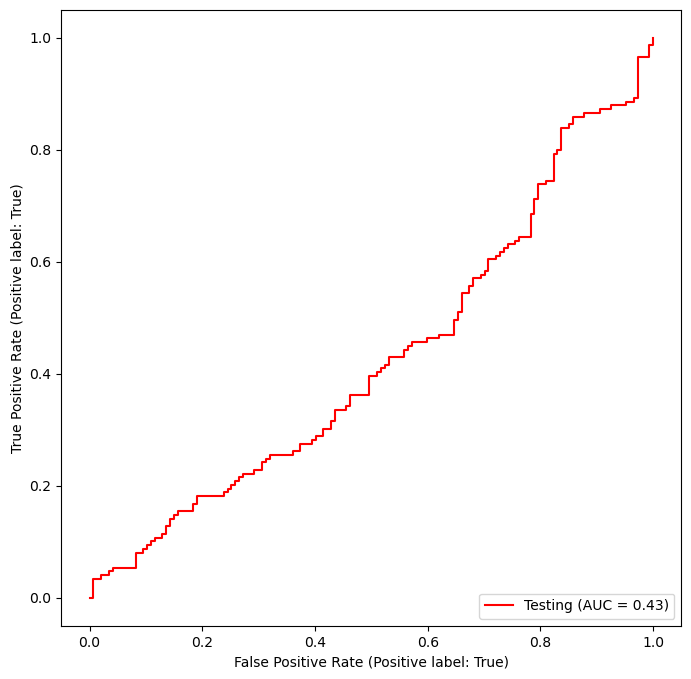

In [112]:
# ROC curve
roc_curve = RocCurveDisplay.from_estimator # shorthand
fig, ax = subplots(figsize=(8,8))
roc_curve(best_svm,
          X_test_5,
          Y_test,
          name='Testing',
          color='r',
          ax=ax);


# Regression
## Linear  AR Model with SK-Learn

In [53]:
cols = ['return', 'log_volume', 'volatility']
Y, train = X['log_volume'], X['train']
X_reg = X.drop(columns=['train'] +cols)



In [54]:
M = LinearRegression()
M.fit(X_reg[train], Y[train])
M.score(X_reg[~train], Y[~train]) # the test result is not good. R^2=0.2

0.19997338230088157

In [55]:
### Adding `day_of_week`
X_day = pd.merge(X_reg, 
                 pd.get_dummies(apple['day_of_week']),
                 on='Date')

In [56]:
M.fit(X_day[train], Y[train])
M.score(X_day[~train], Y[~train])

0.17872110527570284

## Linear AR using statmodels
Here is only for the purpose of practicing using the statsmodels  OLS method. A better way for time searies AR model is to use statsmodels SARIMA model. 

In [57]:
design = MS(X_reg.columns) #add "intercept=False" if no intercept.
X_tr = design.fit_transform(X_reg[train]) 

y = Y[train]
model = sm.OLS(y, X_tr)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,0.0010,0.008,0.129,0.898
return_1,-0.0114,0.008,-1.465,0.143
log_volume_1,0.4693,0.011,42.573,0.000
volatility_1,0.0734,0.009,8.030,0.000
return_2,-0.0164,0.008,-2.106,0.035
log_volume_2,0.0729,0.012,6.053,0.000
volatility_2,-0.0376,0.009,-4.118,0.000
return_3,0.0028,0.008,0.364,0.715
log_volume_3,0.0566,0.012,4.696,0.000
volatility_3,-0.0240,0.009,-2.626,0.009


In [58]:
def calc_r2_MSE(yhat, y):
    """
    Calculate the R^2 and MSE

    INPUT: 
    yhat: predicted value vectors
    y: ground-truth y-values
    
    OUTPUT: tuple (r2, mse)
    """
    r2 = 1- np.sum((yhat-y)**2)/np.sum((y-np.mean(y))**2)
    mse = np.mean((y-yhat)**2)
    return (r2, mse)
    

In [59]:
X_te = design.transform(X_reg[~train])
yhat = results.predict(X_te)
y_test = Y[~train]
#Calculate r^2

calc_r2_MSE(yhat, y_test)


(0.19997338230088169, 0.2226826900933754)

## Variable Selection

In [60]:
# define the scoring function
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 

In [61]:
design = MS(X_reg.columns).fit(X_reg)
Y_ = np.array(Y)
X_ = design.transform(X_reg)
sigma2 = OLS(Y_,X_).fit().scale  #.scale: RSE: residual standard error estimating sigma^2
sigma2

0.627736921302886

In [62]:
neg_Cp = partial(nCp, sigma2) #freeze sigma2 in the function nCp
strategy = Stepwise.first_peak(design, # note have to use design as defined above which is an estimator instance. 
                               direction='forward',
                               max_terms=len(design.terms))
hitters_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp)#default scoring MSE, will choose all variables
hitters_Cp.fit(X_reg, Y) # the same as hitters_Cp.fit(Hitters.drop('Salary', axis=1), Y), as strategy specify the design matrix
hitters_Cp.selected_state_

('log_volume_1',
 'log_volume_2',
 'log_volume_3',
 'log_volume_4',
 'log_volume_5',
 'return_1',
 'return_2',
 'volatility_1',
 'volatility_2',
 'volatility_3',
 'volatility_4',
 'volatility_5')

In [63]:
# Backward Selection
strategy = Stepwise.first_peak(design, # note have to use design as defined above which is an estimator instance. 
                               direction='backward',
                               initial_terms= design.terms,
                               max_terms=len(design.terms))
hitters_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp)#default scoring MSE, will choose all variables
hitters_Cp.fit(X_reg, Y) # the same as hitters_Cp.fit(Hitters.drop('Salary', axis=1), Y), as strategy specify the design matrix
hitters_Cp.selected_state_

('log_volume_1',
 'log_volume_2',
 'log_volume_3',
 'log_volume_4',
 'log_volume_5',
 'return_1',
 'return_2',
 'volatility_1',
 'volatility_2',
 'volatility_3',
 'volatility_4',
 'volatility_5')

## Ridge regression using SKLearning Pipeline and Cross-Validation

In [64]:
ridge = skl.ElasticNet(alpha= 0.01, l1_ratio=0) #note the difference from ElasticNet.path() 
# alpha =0.01 is just temporarily set here. 
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])

K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)

lambdas = 10**np.linspace(8, -2, 100) / Y[train].std() #[yw] why lambdas is chosen to be normalized by Y.std()
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X_reg[train], Y[train])

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=0.01, l1_ratio=0))]),
             param_grid={'ridge__alpha': array([9.91526673e+07, 7.85767931e+07, 6.22707648e+07, 4.93485161e+07,
       3.91078551e+07, 3.09923064e+07, 2.45608728e+07, 1.94640716e+07,
       1.54249439e+07, 1.22240043e+07, 9.68...
       2.08706860e+00, 1.65396618e+00, 1.31073991e+00, 1.03873896e+00,
       8.23182863e-01, 6.52358341e-01, 5.16982829e-01, 4.09700051e-01,
       3.24680284e-01, 2.57303572e-01, 2.03908681e-01, 1.61594142e-01,
       1.28060594e-01, 1.01485831e-01, 8.04257854e-02, 6.37360595e-02,
       5.05097372e-02, 4.00281029e-02, 3.17215870e-02, 2.51388152e-02,
       1.99220811e-02, 1.57879086e-02, 1.25116476e-02, 9.91526673e-03])},
             scoring='neg_mean_squared_error')

In [65]:
grid.best_params_['ridge__alpha'], 

(0.009915266726338525,)

In [66]:
yhat = grid.best_estimator_.predict(X_reg[~train])
calc_r2_MSE(yhat,Y[~train])

(0.20046702306162334, 0.22254528809935445)

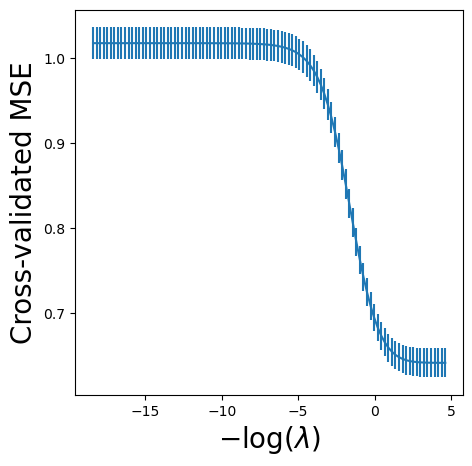

In [67]:
ridge_fig, ax = subplots(figsize=(5,5))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
# ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [68]:
grid_r2 = skm.GridSearchCV(pipe, 
                           param_grid,
                           cv=kfold) #default scoring=R^2 
grid_r2.fit(X_reg[train], Y[train])

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=0.01, l1_ratio=0))]),
             param_grid={'ridge__alpha': array([9.91526673e+07, 7.85767931e+07, 6.22707648e+07, 4.93485161e+07,
       3.91078551e+07, 3.09923064e+07, 2.45608728e+07, 1.94640716e+07,
       1.54249439e+07, 1.22240043e+07, 9.68...
       2.08706860e+00, 1.65396618e+00, 1.31073991e+00, 1.03873896e+00,
       8.23182863e-01, 6.52358341e-01, 5.16982829e-01, 4.09700051e-01,
       3.24680284e-01, 2.57303572e-01, 2.03908681e-01, 1.61594142e-01,
       1.28060594e-01, 1.01485831e-01, 8.04257854e-02, 6.37360595e-02,
       5.05097372e-02, 4.00281029e-02, 3.17215870e-02, 2.51388152e-02,
       1.99220811e-02, 1.57879086e-02, 1.25116476e-02, 9.91526673e-03])})

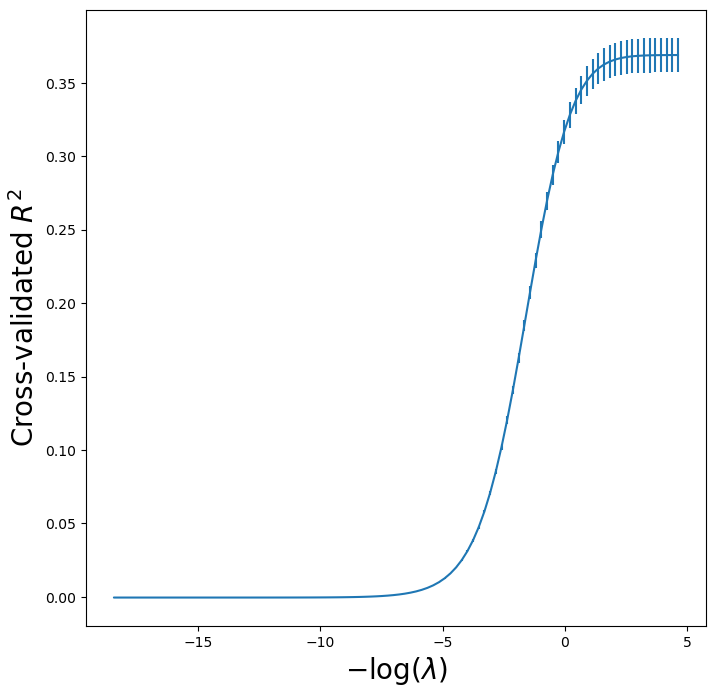

In [69]:
r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);

In [70]:
yhat = grid_r2.best_estimator_.predict(X_reg[~train])
calc_r2_MSE(yhat,Y[~train])

(0.20046702306162334, 0.22254528809935445)

### Fast Cross-Validation for Solution Paths using ElasticNetCV()
The ridge, lasso, and elastic net can be efficiently fit along a sequence of $\lambda$ values, creating what is known as a *solution path* or *regularization path*. Hence there is specialized code to fit
such paths, and to choose a suitable value of $\lambda$ using cross-validation. Even with
identical splits the results will not agree *exactly* with our `grid`
above because the standardization of each feature  in `grid` is carried out on each fold,
while in `pipeCV` below it is carried out only once.
Nevertheless, the results are similar as the normalization
is relatively stable across folds.

In [71]:
lambdas = 10**np.linspace(8, -2, 100) / Y[train].std() #[yw] why lambdas is chosen to be normalized by Y.std()

ridgeCV = skl.ElasticNetCV(alphas=lambdas, # ElasticNetCV accepts a sequence of alphas
                           l1_ratio=0,#ridge
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), # scaling is done once, and then Cross-val
                         ('ridge', ridgeCV)])
pipeCV.fit(X_reg[train], Y[train])
tuned_ridge = pipeCV.named_steps['ridge']

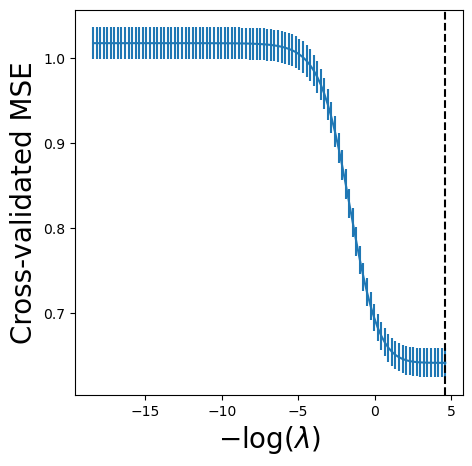

In [72]:
ridgeCV_fig, ax = subplots(figsize=(5,5))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
# ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [73]:
tuned_ridge.alpha_, np.min(tuned_ridge.mse_path_.mean(1))

(0.009915266726338525, 0.641632551165717)

In [74]:
tuned_ridge.coef_, tuned_ridge.intercept_

(array([-1.10707633e-02,  4.65838410e-01,  7.61502479e-02, -1.63727462e-02,
         7.62264990e-02, -3.69897970e-02,  2.84660521e-03,  5.77802098e-02,
        -2.44335566e-02,  8.96324322e-03,  6.11548207e-02, -1.75038681e-02,
        -6.27834721e-05,  6.58906951e-02, -2.53912218e-02]),
 0.0009161973337824278)

In [75]:
yhat = tuned_ridge.predict(X_reg[~train])
calc_r2_MSE(yhat,Y[~train])

(0.19934681975422808, 0.2228570900824681)

### Fast Cross Validation for a solution path for  Lasso using ElasticNetCV()
We now ask whether the lasso can yield
either a more accurate or a more interpretable model than ridge
regression. In order to fit a lasso model, we once again use the
`ElasticNetCV()`  function; however, this time we use the argument
`l1_ratio=1`. Other than that change, we proceed just as we did in
fitting a ridge model.

In [76]:
lassoCV = skl.ElasticNetCV(n_alphas=100, #test 100 alpha values
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X_reg[train], Y[train])
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.0036485643518026282

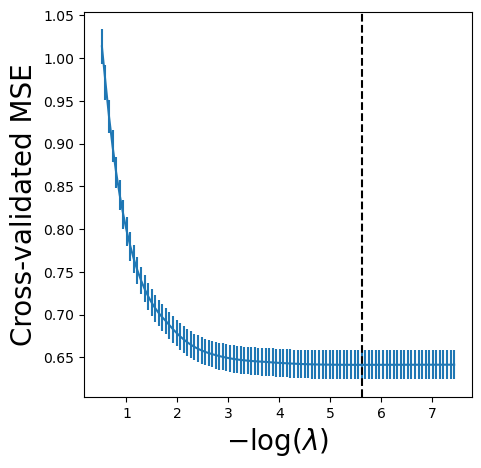

In [77]:
lassoCV_fig, ax = subplots(figsize=(5,5))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
# ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [78]:
np.min(tuned_lasso.mse_path_.mean(1)), tuned_lasso.coef_, 

(0.6414242348883088,
 array([-0.00833788,  0.47544532,  0.06772294, -0.01251405,  0.06875301,
        -0.03318071,  0.        ,  0.05420293, -0.01944543,  0.00609821,
         0.05792846, -0.01250511,  0.        ,  0.06306209, -0.02051067]))

In [79]:
yhat = tuned_lasso.predict(X_reg[~train])
calc_r2_MSE(yhat,Y[~train])

(0.20118664970669153, 0.22234498426740507)

### Calculate the Lasso coefficient along a path using Lasso.path()
This can be done using ElasticNet.path() as we did befor for ridge. 

In [80]:
lambdas, soln_array = skl.Lasso.path(X_reg[train], # this can be done using ElasticNet.path
                                    Y[train],
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=X_reg.columns,
                         index=-np.log(lambdas))
# soln_path

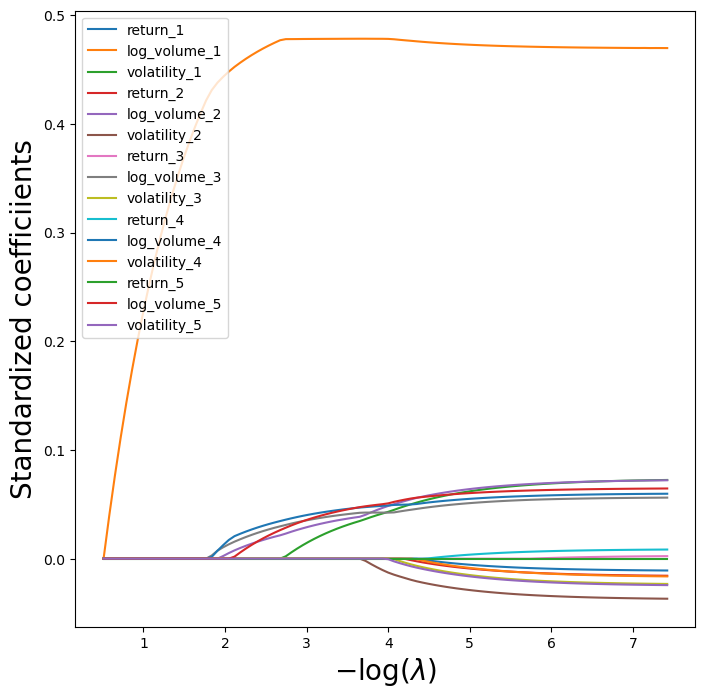

In [81]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

## PCA Regression

In [82]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('scaler', scaler), 
                 ('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X_reg[train], Y[train])
pipe.named_steps['linreg'].coef_

array([0.25981628, 0.12324188])

In [83]:
pipe.named_steps['pca'].explained_variance_ratio_

array([0.22912884, 0.0931941 ])

In [84]:

yhat = pipe.predict(X_reg[~train])
calc_r2_MSE(yhat, Y[~train])

(0.01110809230837384, 0.2752522295441419)

In [85]:
param_grid = {'pca__n_components': range(1, len(X_reg.columns))}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X_reg[train], Y[train]);

In [86]:
yhat = grid.best_estimator_.predict(X_reg[~train])
calc_r2_MSE(yhat, Y[~train])

(0.19588674326582645, 0.22382018196381334)

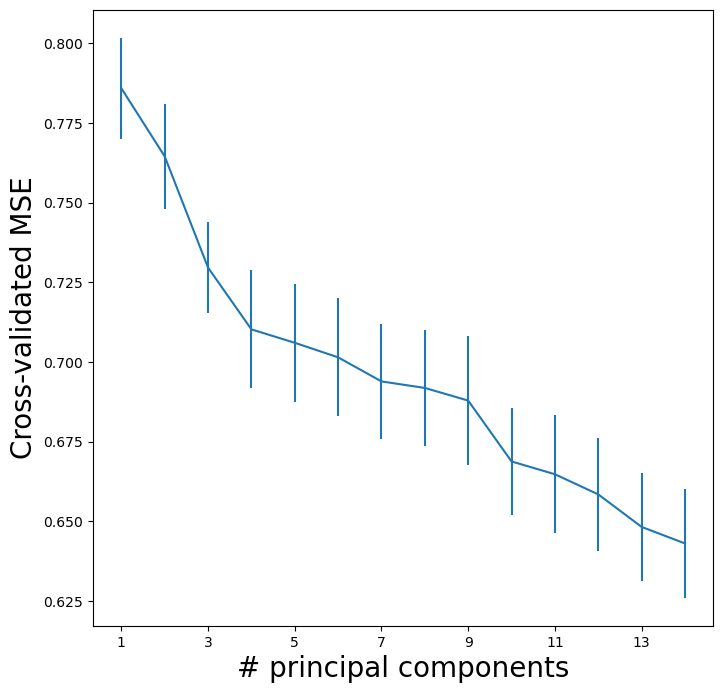

In [87]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2]);
# ax.set_ylim([50000,250000]);

### Fit a null model with only intercept
The CV score is provided for each possible number of components from
1 to 19 inclusive. The `PCA()` method complains
if we try to fit an intercept only with `n_components=0`
so we also compute the MSE for just the null model with
these splits.

In [88]:
Xn = np.zeros((X_reg.shape[0], 1)) 
cv_null = skm.cross_validate(linreg,
                             X_reg[train],
                             Y[train],
                             cv=kfold,
                             scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()



0.6416328996418488

 ### Partial Least Squres

In [89]:
pls = PLSRegression(n_components=2, 
                    scale=True) # standarsize the data 
pls.fit(X_reg[train], Y[train]) #X has no- intercept

PLSRegression()

In [90]:
param_grid = {'n_components':range(1, 20)}
grid = skm.GridSearchCV(pls,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X_reg[train], Y[train])

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

In [91]:
yhat = grid.best_estimator_.predict(X_reg[~train])
calc_r2_MSE(yhat.squeeze(), Y[~train])

(0.20047839646997379, 0.22254212237822596)

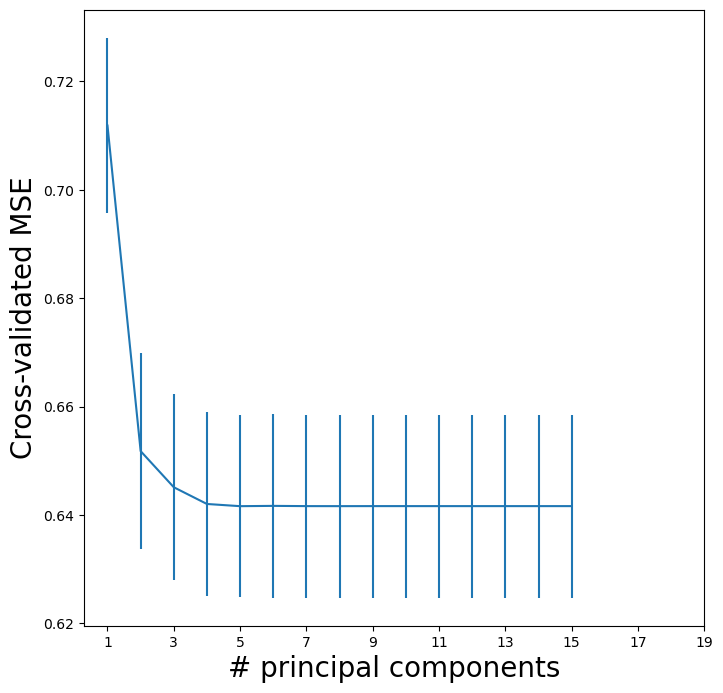

In [91]:
pls_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2]);
# ax.set_ylim([50000,250000]);

## RF Regression

In [96]:
rf = RF(max_features='sqrt', random_state=0, n_estimators=500,)
rf.fit(X_reg[train], Y[train])

RandomForestRegressor(max_features='sqrt', n_estimators=500, random_state=0)

(0.14855483869998498, 0.23699473841329446)

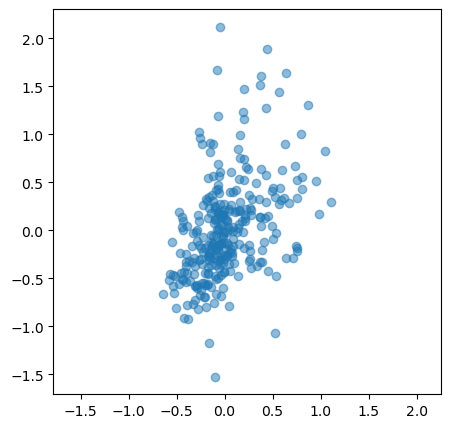

In [100]:
ax = subplots(figsize=(5,5))[1]
y_hat_rf = rf.predict(X_reg[~train])

ax.scatter(y_hat_rf, Y[~train], alpha=0.5)
plt.axis('equal')
calc_r2_MSE(y_hat_rf, Y[~train])

In [101]:
feature_names = list(X_reg.columns)
feature_imp = pd.DataFrame(
    {'importance':rf.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
log_volume_1,0.249185
log_volume_2,0.101215
log_volume_3,0.072206
log_volume_4,0.065246
log_volume_5,0.063621
volatility_1,0.062642
return_1,0.053319
return_2,0.043337
volatility_2,0.043110
return_3,0.042316


## Gradient Boosting Regression

In [102]:
boost = GBR(n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost.fit(X_reg[train], Y[train])

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

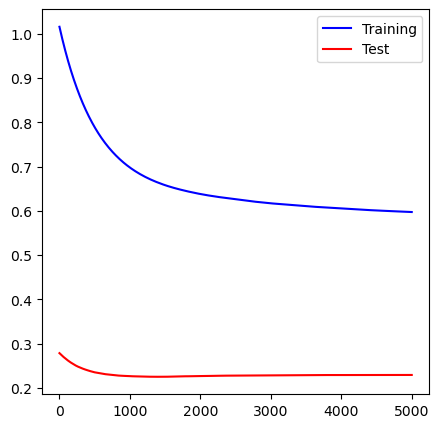

In [103]:
test_error = np.zeros_like(boost.train_score_)
for idx, y_ in enumerate(boost.staged_predict(X_reg[~train])):
   test_error[idx] = np.mean((Y[~train] - y_)**2)

plot_idx = np.arange(boost.train_score_.shape[0])
ax = subplots(figsize=(5,5))[1]
ax.plot(plot_idx,
        boost.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();


In [104]:
y_hat_boost = boost.predict(X_reg[~train]);
calc_r2_MSE(y_hat_boost, Y[~train])

(0.17726474416964144, 0.22900350557069668)

## Bayesian Additive Regression Trees

In [94]:
bart_ = BART(random_state=0, burnin=5, ndraw=15) #num_trees=200, max_states=100
# ndraw: number of iterations or samples to draw from the posterior distribution after the burn-in 
bart_.fit(X_reg[train], Y[train])


BART(burnin=5, ndraw=15, random_state=0)

In [101]:

# yhat_test = bart_.predict(X_reg[~train].astype(np.float32))
yhat_test = bart_.predict(np.float32(X_reg[~train]))
calc_r2_MSE(yhat_test, Y[~train])


(0.13185137162609006, 0.24164404994820135)

In [103]:
var_inclusion = pd.Series(bart_.variable_inclusion_.mean(0),
                               index=X_reg.columns)
var_inclusion.sort_values(ascending=False)


log_volume_1    32.800000
log_volume_2    25.200000
log_volume_3    24.200000
log_volume_4    22.800000
return_1        17.666667
volatility_1    17.666667
log_volume_5    16.533333
return_5        15.333333
return_4        14.933333
volatility_3    14.066667
volatility_4    13.733333
volatility_2    12.733333
volatility_5    12.733333
return_3        12.533333
return_2        12.200000
dtype: float64

### RNN Model

For an input shape `(5,3)`, each row represents a lagged version of the three variables.
The `nn.RNN()` layer also expects the first row of each
observation to be earliest in time, so we must reverse the current order.

In [63]:
# Reshaping the data
ordered_cols = []
for lag in range(5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col, lag))
X = X.reindex(columns=ordered_cols)
# X.columns

In [65]:
X_rnn = X.to_numpy().reshape((-1,5,3))
# X_rnn.shape

In [66]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(3, #number of features for each time step
                          12, #hidden size
                          batch_first=True) #batch size as the first dim
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:,-1])) #extract the last time step from RNN
        return torch.flatten(val)
nyse_model = NYSEModel()

In [67]:
datasets = []
for mask in [train, ~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, Y_t))
nyse_train, nyse_test = datasets

In [68]:
len(nyse_train), len(nyse_test)

(10493, 296)

In [69]:
nyse_test.tensors[0].shape, nyse_test.tensors[1].shape

(torch.Size([296, 5, 3]), torch.Size([296]))

In [70]:
summary(nyse_model,
        input_data=X_rnn_t,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [296, 5, 3]               [296]                     --
├─RNN: 1-1                               [296, 5, 3]               [296, 5, 12]              204
├─Dropout: 1-2                           [296, 12]                 [296, 12]                 --
├─Linear: 1-3                            [296, 12]                 [296, 1]                  13
Total params: 217
Trainable params: 217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.31
Input size (MB): 0.02
Forward/backward pass size (MB): 0.14
Params size (MB): 0.00
Estimated Total Size (MB): 0.16

In [71]:
max_num_workers = rec_num_workers()

In [72]:
nyse_dm = SimpleDataModule(nyse_train,
                           nyse_test,
                           num_workers=min(4, max_num_workers),
                           validation=nyse_test,
                           batch_size=64)
                           

In [79]:
# Example the minibatch size of y and the output size in each minibatch
for idx, (x, y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(idx, "minibatch input size:", y.size(), "model minibatch output size:", out.size())
    
    if idx ==0:
        break

0 minibatch input size: torch.Size([64]) model minibatch output size: torch.Size([64])


In [80]:
nyse_optimizer = RMSprop(nyse_model.parameters(),
                         lr=0.001)
nyse_module = SimpleModule.regression(nyse_model,
                                      optimizer=nyse_optimizer,
                                      metrics={'r2':R2Score()})

In [81]:
nyse_trainer = Trainer(deterministic=False,
                       max_epochs=20,
                       callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module,
                 datamodule=nyse_dm)
nyse_trainer.test(nyse_module,
                  datamodule=nyse_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | NYSEModel | 217   
1 | loss  | MSELoss   | 0     
------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 164/164 [00:00<00:00, 168.95it/s, v_num=17]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 164/164 [00:00<00:00, 166.27it/s, v_num=17]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 405.02it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.22700099647045135
         test_r2            0.18445897102355957
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.22700099647045135, 'test_r2': 0.18445897102355957}]

### Build a linear and non-linear AR model using Torch 

In [82]:
datasets = []
for mask in [train, ~train]:
    X_day_t = torch.tensor(
                   np.asarray(X_day[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t, Y_t))
day_train, day_test = datasets

In [100]:
# day_train.tensors[0].shape

torch.Size([10493, 20])

In [83]:
day_dm = SimpleDataModule(day_train,
                          day_test,
                          num_workers=min(4, max_num_workers),
                          validation=day_test,
                          batch_size=64)

In [84]:
X_day.shape

(10789, 20)

In [86]:
class NonLinearARModel(nn.Module):
    def __init__(self):
        super(NonLinearARModel, self).__init__()
        self._forward = nn.Sequential(nn.Flatten(), #flatten a multi-dim tensor into a 1-d tensor while keeping the batch size
                                      nn.Linear(20, 32), 
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(32, 1))
    def forward(self, x):
        return torch.flatten(self._forward(x))


In [87]:
nl_model = NonLinearARModel()
nl_optimizer = RMSprop(nl_model.parameters(),
                           lr=0.001)
nl_module = SimpleModule.regression(nl_model,
                                        optimizer=nl_optimizer,
                                        metrics={'r2':R2Score()})

In [88]:
nl_trainer = Trainer(deterministic=False,
                         max_epochs=20,
                         callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module, datamodule=day_dm)
nl_trainer.test(nl_module, datamodule=day_dm) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | NonLinearARModel | 705   
1 | loss  | MSELoss          | 0     
-------------------------------------------
705       Trainable params
0         Non-trainable params
705       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 19: 100%|██████████| 164/164 [00:00<00:00, 194.34it/s, v_num=18]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 164/164 [00:00<00:00, 190.82it/s, v_num=18]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 416.50it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.22326382994651794
         test_r2            0.19788551330566406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.22326382994651794, 'test_r2': 0.19788551330566406}]

In [89]:
class LinearARModel(nn.Module):
    def __init__(self):
        super(LinearARModel, self).__init__()
        self._forward = nn.Sequential(nn.Flatten(), #flatten a multi-dim tensor into a 1-d tensor while keeping the batch size
                                    #   nn.Linear(20, 32), 
                                    #   nn.ReLU(),
                                    #   nn.Dropout(0.5),
                                      nn.Linear(20, 1))
    def forward(self, x):
        return torch.flatten(self._forward(x))


In [90]:
linearAR_model = LinearARModel()
linearAR_optimizer = RMSprop(linearAR_model.parameters(),
                           lr=0.001)
linearAR_module = SimpleModule.regression(linearAR_model,
                                        optimizer=linearAR_optimizer,
                                        metrics={'r2':R2Score()})

In [91]:
linearAR_trainer = Trainer(deterministic=False,
                         max_epochs=20,
                         callbacks=[ErrorTracker()])
linearAR_trainer.fit(linearAR_module, datamodule=day_dm)
linearAR_trainer.test(linearAR_module, datamodule=day_dm) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | LinearARModel | 21    
1 | loss  | MSELoss       | 0     
----------------------------------------
21        Trainable params
0         Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 19: 100%|██████████| 164/164 [00:00<00:00, 223.67it/s, v_num=19]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 164/164 [00:00<00:00, 219.73it/s, v_num=19]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 322.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.22887705266475677
         test_r2            0.1777191162109375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.22887705266475677, 'test_r2': 0.1777191162109375}]